In [5]:
# 필요한 module import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 전처리
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# 사용하는 모델
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor

In [6]:
# Ozone 데이터를 이용해서
# 결측치 삭제, 이상치 삭제로 데이터를 정제하고
# 정규화 처리 당연히 진행
# LinearRegression Model을 구현해서
# 태양광 310, 바람 15, 온도 80일 겨우 오존량을 예측
# KNN을 이용해서 똑같은 데이터에 대한 예측 진행!

In [7]:
# 1.Raw Data Loading
ozone = pd.read_csv('/content/drive/MyDrive/KDT/data/ozone.csv')

df = ozone[['Solar.R', 'Wind', 'Temp', 'Ozone']]
display(ozone.head())

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5


In [8]:
# 2. 데이터 전처리
# 2-1. 결측치 처리 (지금은 삭제 처리)
new_df = df.dropna(how='any', inplace=False)

# 2-2. 이상치 처리 (지금은 삭제 처리)
zscore_threshold = 1.8
mask = np.abs(stats.zscore(new_df['Ozone'])) <= zscore_threshold
df1 = new_df.loc[mask]

# 3. 데이터 정규화
# 데이터 분리(편의를 위해)
x_data = df1.drop('Ozone', axis=1, inplace=False).values # 헷갈리지 말자 values 붙여야 2차원 numpy array 만들어짐
t_data = df1['Ozone'].values.reshape(-1, 1)

scaler_x = MinMaxScaler()
scaler_t = MinMaxScaler()

scaler_x.fit(x_data) # 최대 최소값 전달
scaler_t.fit(t_data)

x_data_norm = scaler_x.transform(x_data)
t_data_norm = scaler_t.transform(t_data)

In [9]:
# 테스트 데이터 생성
test_data = np.array([[310, 15, 80]])

In [10]:
# LinearRegression Model (sklearn - 정규화하지 않은 데이터 이용)
sklearn_model_1 = linear_model.LinearRegression()
sklearn_model_1.fit(x_data, t_data)

# 예측
result = sklearn_model_1.predict(test_data)
print(result) # [[38.26325246]]

[[38.26325246]]


In [11]:
# LinearRegression Model (sklearn - 정규화 데이터 이용)
sklearn_model_2 = linear_model.LinearRegression()
sklearn_model_2.fit(x_data_norm, t_data_norm)

# 예측
test_data_norm = scaler_x.transform(test_data)

result_norm = sklearn_model_2.predict(test_data_norm)
result = scaler_t.inverse_transform(result_norm)
print(result) # [[38.26325246]]

[[38.26325246]]


In [12]:
# KNN Model (sklearn - 정규화하지 않은 데이터 이용)
knn_regressor_1 = KNeighborsRegressor(n_neighbors=2) # n_neighbor는 hyper parameter
knn_regressor_1.fit(x_data, t_data) # 얘는 학습이 아니고 흩뿌리는 개념 (각각 거리 구함)

result_knn_1 = knn_regressor_1.predict(test_data)
print(result_knn_1) # [[25.5]]

[[25.5]]


In [13]:
# KNN Model (sklearn - 정규화 데이터 이용)
knn_regressor_2 = KNeighborsRegressor(n_neighbors=2)
knn_regressor_2.fit(x_data_norm, t_data_norm)

test_data_norm = scaler_x.transform(test_data)
result_knn_2_norm = knn_regressor_2.predict(test_data_norm)
result_knn_2 = scaler_t.inverse_transform(result_knn_2_norm)
print(result_knn_2)

[[33.]]


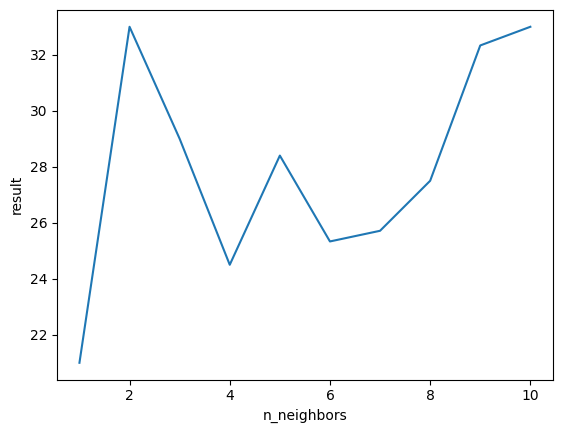

In [14]:
# n_neighbors에 따른 result값 변화량

neighbors = []
result = []

for i in range(1, 11):
    knn_regressor = KNeighborsRegressor(n_neighbors=i)
    neighbors.append(i)
    knn_regressor.fit(x_data_norm, t_data_norm)

    test_data_norm = scaler_x.transform(test_data)
    result_knn_norm = knn_regressor.predict(test_data_norm)
    result_knn = scaler_t.inverse_transform(result_knn_norm)
    result.append(result_knn.ravel())

plt.plot(neighbors, result)
plt.xlabel('n_neighbors')
plt.ylabel('result')
plt.show()

In [15]:
# 우리 Ozone 데이터를 수정해서 사용할 거에요!
# 원본데이터가 가지고 있는 결측치와 이상치를 모두 삭제하지 말고
# 수정해서 사용할거에요!
# 이렇게 수정된 데이터를 이용해서 sklearn의 Linear Regression과
# Tensorflow Keras를 이용해서 학습시키고 특정 데이터로 예측을 진행

# 1. 독립변수에 대한 결측치는 median으로 처리
# 2. 독립변수에 대한 이상치는 mean으로 처리
# 3. 종속변수에 대한 이상치는 검출한 후 mean으로 처리
# 4. 정규화 진행
# 5. 종속변수에 대한 결측치는 KNN을 이용해서 예측값으로 처리

In [22]:
%reset

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings(action='ignore')

# Raw Data Loading
df = pd.read_csv('/content/drive/MyDrive/KDT/data/ozone.csv')
training_data = df

x_data = training_data[['Solar.R','Wind','Temp']]
t_data = training_data['Ozone']

# 1. 먼저 독립변수에 대한 결측치를 검출한 후 median값으로 처리하겠습니다.
#    mean으로 처리하지 않는 이유는 이상치때문입니다.
for col in x_data.columns:
    col_median = np.nanmedian(x_data[col])
    x_data[col].loc[x_data[col].isnull()] = col_median

# 2. 독립변수에 대한 이상치를 검출한 후 mean 값으로 처리하겠습니다.
zscore_threshold = 1.8 # zscore outliers 임계값 (2.0이하가 optimal)

for col in x_data.columns:
    outliers = x_data[col][(np.abs(stats.zscore(x_data[col])) > zscore_threshold)]
    col_mean = np.mean(x_data.loc[~x_data[col].isin(outliers),col])
    print(col_mean)
    x_data.loc[x_data[col].isin(outliers),col] = col_mean

# 3. 종속변수에 대한 이상치를 검출한 후 mean 값으로 처리하겠습니다.
#    종속변수에 대한 이상치는 없음.
outliers = t_data[(np.abs(stats.zscore(t_data)) > zscore_threshold)]
col_mean = np.mean(t_data[~t_data.isin(outliers)])
print(col_mean)
t_data[t_data.isin(outliers)] = col_mean


# 4. 정규화를 진행합니다.

scaler_x = MinMaxScaler()  # MinMaxScaler 클래스의 인스턴스 생성.
scaler_t = MinMaxScaler()  # MinMaxScaler 클래스의 인스턴스 생성.

scaler_x.fit(x_data.values)
scaler_t.fit(t_data.values.reshape(-1,1))

x_data_norm = scaler_x.transform(x_data.values)
t_data_norm = scaler_t.transform(t_data.values.reshape(-1,1)).ravel()


# 5. 종속변수에 대한  결측치는 KNN을 이용하여 예측값을 사용합니다.
#    학습에 사용될 x_data_train_norm과 t_data_train_norm을 구합니다.
x_data_train_norm = x_data_norm[~np.isnan(t_data_norm)]
t_data_train_norm = t_data_norm[~np.isnan(t_data_norm)]

knn_regressor = KNeighborsRegressor(n_neighbors=2)
knn_regressor.fit(x_data_train_norm, t_data_train_norm)


knn_predict = knn_regressor.predict(x_data_norm[np.isnan(t_data_norm)])
t_data_norm[np.isnan(t_data_norm)] = knn_predict
print(knn_predict)

# 최종적으로 얻은 데이터
# x_data_norm
# t_data_norm
# 이 데이터를 이용하여 sklearn과 tensorflow 2.x 구현을 진행합니다.

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
198.6013986013986
9.820279720279721
78.75524475524476
42.12931034482759
[0.08383234 0.18562874 0.07784431 0.19161677 0.26946108 0.28143713
 0.17664671 0.13173653 0.26047904 0.53592814 0.19161677 0.32634731
 0.61377246 0.61377246 0.19760479 0.19760479 0.11676647 0.07784431
 0.28742515 0.21556886 0.11676647 0.11676647 0.08083832 0.07784431
 0.04191617 0.1497006  0.23652695 0.1497006  0.32335329 0.67365269
 0.19760479 0.67664671 0.23353293 0.11377246 0.08682635 0.51796407
 0.08682635]


In [19]:
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD

test_data = [[310,15,80]]


# sklearn 구현
model = LinearRegression()
model.fit(x_data_norm,t_data_norm)
result = model.predict(scaler_x.transform(test_data))

print('sklearn result : {}'.format(scaler_t.inverse_transform(result.reshape(-1,1))))

# sklearn result : [[38.75927452]]


# tensorflow 2.x 구현
keras_model = Sequential()

keras_model.add(Flatten(input_shape=(3,)))
keras_model.add(Dense(1, activation='linear'))

keras_model.compile(optimizer=SGD(learning_rate=1e-2), loss='mse')

keras_model.fit(x_data_norm,
                t_data_norm,
                epochs=5000,
                verbose=0)

keras_result = keras_model.predict(scaler_x.transform(test_data))

print('tensorflow result : {}'.format(scaler_t.inverse_transform(keras_result.reshape(-1,1))))

# tensorflow result : [[38.64248]]


sklearn result : [[38.75927452]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
tensorflow result : [[38.88299]]


In [ ]:
# 이진 분류에서의 Linear Regression 한계 -> Logistic Regression 사용!
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD

# 1. Training Data Set
x_data = np.array([1, 3, 5, 7, 10, 13]).reshape(-1, 1) # 공부시간
t_data = np.array([0, 0, 0, 0, 1, 1]).reshape(-1, 1) # 합격여부

# 2. Model 구현
model = Sequential()
model.add(Flatten(input_shape=(1,)))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer=SGD(learning_rate=1e-4), loss='mse')

# 3. 학습 진행
model.fit(x_data, t_data, epochs=1000, verbose=1)

In [ ]:
# 4. 예측
result = model.predict(np.array([[9]]))
print(result) # [[0.5848966]]

result = model.predict(np.array([[11]]))
print(result) # [[0.705537]]

result = model.predict(np.array([[6]]))
print(result) # [[0.40393612]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
[[0.5848966]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
[[0.705537]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
[[0.40393612]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD

# 1. Training Data Set
# 여기서 30은 수치적으론 이상치이지만 가능한 숫자이기 때문에 이상치 X
x_data = np.array([1, 3, 5, 7, 10, 13, 30]).reshape(-1, 1)
t_data = np.array([0, 0, 0, 0, 1, 1, 1]).reshape(-1, 1)

# 2. Model 구현
model = Sequential()
model.add(Flatten(input_shape=(1,)))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer=SGD(learning_rate=1e-4), loss='mse')

# 3. 학습 진행
model.fit(x_data, t_data, epochs=1000, verbose=1)

In [ ]:
# 4. 예측
result = model.predict(np.array([[9]]))
print(result) # [[0.4058821]]

result = model.predict(np.array([[11]]))
print(result) # [[0.48496366]]

result = model.predict(np.array([[6]]))
print(result) # [[0.2872598]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[[0.4058821]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[[0.48496366]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[0.2872598]]


In [ ]:
# Logistic 글 쓸때 Linear에서 loss함수 Logistic에서 loss함수 다른이유 (convex 함수 특징) 찾아보기!

In [ ]:
# Logistic Regression
# Lojistic을 위한 적합한 Data Set이 mglearn 안에 있어서 사용해요!
# mglearn library를 설치하고 사용해 보아요!
# colab을 사용하면 CPU, Memory, Disk를 제공받아요!
# 제공받은 Disk에 unbuntu Linux가 설치되어서 제공되요!
# 특정 library를 설치하려면 pip를 이용해야 해요!
!pip install mglearn

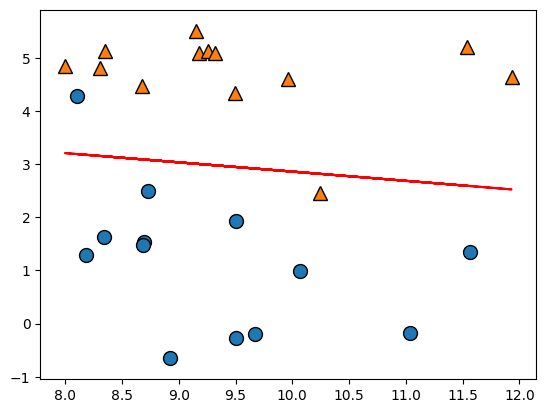

In [ ]:
import numpy as np
from sklearn import linear_model
import mglearn
import matplotlib.pyplot as plt

# 1. Training Data Set Loading
x_data, t_data = mglearn.datasets.make_forge()
# print(x_data) # 2차원 0번째 컬럼을 x축 좌표로, 1번째 컬럼을 y축 좌표로.
# print(t_data) # [1 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0]

# plt.scatter(x_data[:,0], x_data[:,1])
# plt.show()

mglearn.discrete_scatter(x_data[:,0], x_data[:,1], t_data)

# Linear Regression 모델을 만들고 학습까지 시켜보아요!
model = linear_model.LinearRegression()
model.fit(x_data[:,0].reshape(-1, 1), x_data[:,1].reshape(-1, 1))

# 모델이 생성되고 당연히 1차 직선으로 생성되요!
# 당연히 w와 b가 생성되고,
# 이 값을 ㅣ용해서 직선을 그려보아요!
plt.plot(x_data[:,0], x_data[:,0] * model.coef_.ravel() + model.intercept_.ravel(), color='r')
plt.show() # 이진 데이터에 대해 LinearRegression을 그리면 데이터를 나누는 기준선이 됨!
# 선에서 멀어질수록 확률이 높은 것 !
# Logistic은 이에 따라 어느영역에 들어가는지 판단 -> Linear를 기반으로 !

In [ ]:
# 이번에는 admission Data Set을 이용해서
# Logistic Regression을 구현해 보아요!

# 필요한 모듈 import
%reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 전처리
# 결측치가 있으면 삭제
# 이상치가 있으면 처리 (종속변수는 0 or 1이가 때문에 지대점!) -> 근데 처리안함 ㅋㅋ (실제데이터로 가정)
# 정규화 (MinMaxScaler) 이상치 있으면 정규화에도 문제 생기긴함...
from sklearn.preprocessing import MinMaxScaler

# 모델 구현(2가지 방식으로)
# 1. sklearn으로 구현
# 2. Tensorflow Keras로 구현
from sklearn import linear_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
# 1. Raw Data Loading
df = pd.read_csv('/content/drive/MyDrive/KDT/data/admission.csv')
display(df.head())

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


admit    0
gre      0
gpa      0
rank     0
dtype: int64


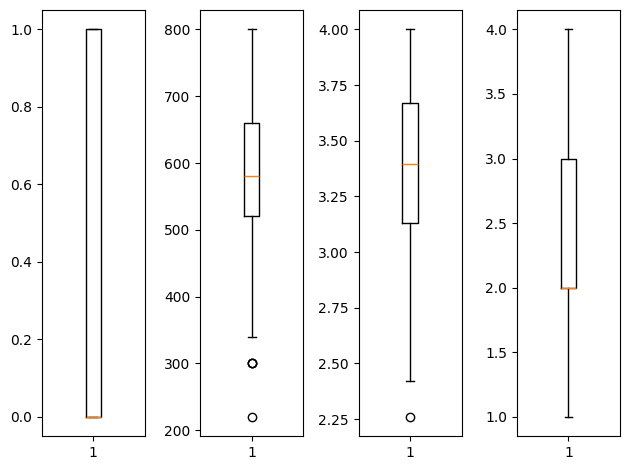

In [ ]:
# 2. 데이터 전처리
# 2-1. 결측치 처리
print(df.isnull().sum()) # 확인결과 결측치는 없어요!

# 2-2. 이상치 처리 (확인만 할거에요!)
fig = plt.figure()
ax_admit = fig.add_subplot(1, 4, 1)
ax_gre = fig.add_subplot(1, 4, 2)
ax_gpa = fig.add_subplot(1, 4, 3)
ax_rank = fig.add_subplot(1, 4, 4)

ax_admit.boxplot(df['admit'].values)
ax_gre.boxplot(df['gre'].values)
ax_gpa.boxplot(df['gpa'].values)
ax_rank.boxplot(df['rank'].values)

plt.tight_layout()
plt.show()

# 2-3. 정규화 처리
x_data = df.drop('admit', axis=1, inplace=False).values
t_data = df['admit'].values.reshape(-1, 1) # 이미 0과 1의 값만 가지고 있기 때문에 정규화 필요 x

scaler = MinMaxScaler()
scaler.fit(x_data)
x_data_norm = scaler.transform(x_data)

In [ ]:
# Model 구현
# sklearn으로 구현
sklearn_model = linear_model.LogisticRegression()
sklearn_model.fit(x_data_norm, t_data.ravel()) # Logistic은 t_data 입력 시 1차원으로 입력

# 예측 => gre 600, gpa 3.8, rank 1 합격여부
sklearn_result = sklearn_model.predict(scaler.transform(np.array([[600, 3.8, 1]])))
sklearn_result_proba = sklearn_model.predict_proba(scaler.transform(np.array([[600, 3.8, 1]])))
print(sklearn_result) # [1]
print(sklearn_result_proba) # [[0.45453933 0.54546067]] 54.5% 확률로 합격

[1]
[[0.45453933 0.54546067]]


In [ ]:
# Tensorflow Keras model 구현
keras_model = Sequential()
keras_model.add(Flatten(input_shape=(3,)))
keras_model.add(Dense(units=1, activation='sigmoid'))
keras_model.compile(optimizer=SGD(learning_rate=1e-4), loss='binary_crossentropy')
keras_model.fit(x_data_norm, t_data, epochs=500, verbose=1)

In [ ]:
keras_result = keras_model.predict(scaler.transform(np.array([[600, 3.8, 1]])))
print(keras_result) # [[0.63557833]] 63.6% 확률로 합격

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
[[0.63557833]]
